# Feature Engineering

## 特征工程的目标

特征工程的目标很简单：就是为了使您的数据更适合机器学习模型的特征。这可能意味着让您的数据更易于预测，也可能意味着使您的数据更易于理解。


你可能会进行特征工程来：

- 改进模型的预测性能
- 减少计算或数据需求
- 提高结果的可解释性



## 特征工程的方法
- 特征转换：将特征转换为更适合模型的形式。
    - 将分类特征转换为数字特征，比如one-hot编码
    - 将数字特征转换为分类特征，比如分箱 binning。 
        - `pd.cut()`用于自定义的或者等宽的区间分箱优先保证区间大小相同
        - `pd.qcut()`用于分位数分箱优先保证每个箱子的数据量相同
- 特征生成：从现有特征中生成新特征，使模型更容易学习
- 特征选择：选择最有用的特征，以便减少数据和模型的开销





In [11]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. BaseLine Model
BaseLine Model是指在没有进行任何特征工程的情况下，直接使用原始数据进行建模，得到的模型称为BaseLine Model。
一般来说，我们的目标是在BaseLine Model的基础上，通过特征工程，使得模型的效果有所提升。

Baseline Model一般使用最简单的模型，比如线性回归、逻辑回归、决策树等等。当模型完成后，使用一个评价指标来评价模型的效果，比如回归问题中常用的MSE、MAE、R2等，分类问题中常用的AUC、KS、F1等。

在得到Baseline Model的效果后，我们就可以进行特征工程，将特征进行组合、转换、筛选等等，然后再次训练模型，得到新的模型效果。如果新的模型效果比Baseline Model的效果要好，那么说明我们的特征工程是有效的。

在进行特征工程和模型优化时，是否应该保持与基线模型相同的算法，这取决于你的目标和实验设计。通常，有两种主要的方法：

1. **保持相同算法，改变特征选择**：这种方法的优点在于它可以让你直接评估特征工程的效果。如果你在特征工程之后仍然使用随机森林算法，那么任何性能上的提升或下降都可以直接归因于新特征的影响。这样做有助于理解哪些特征是有用的，哪些可能不是。

2. **改变算法和特征选择**：另一种方法是在特征工程之后尝试不同的算法。这种方法可以帮助你找到最适合新特征集的模型。有时，新的特征可能更适合不同类型的算法。例如，一些特征可能对某些模型（如基于树的模型）更有效，而对其他模型（如线性模型）效果不佳。

在实际操作中，你可以先采用第一种方法，只改变特征选择，以评估这些新特征对模型性能的影响。一旦确定了有效的特征集，再尝试不同的算法，以找到最佳的模型配置。这种迭代方法可以帮助你更全面地理解数据，并找到最优的模型。


# 2. Mutual Information (MI)
当处理一个新数据集，可能有很多特征，此时我们需要构建一个`feature utility metric`，来帮助我们选择最有用的特征。这个metric可以用来衡量每个特征与目标变量之间的相关性. 

同时，使用MI得分可以为我们找到最有用的特征提供指导。

***
---
## 2.1 Definition of Mutual Information
相互信息（Mutual Information, MI）是一种衡量两个变量之间共享信息量的度量。它告诉我们一个变量包含关于另一个变量的多少信息。在数据科学和信息论中，这是一个非常重要的概念，用于理解变量之间的关系和依赖性。

与相关性不同，相互信息可以捕获任何类型的依赖性，包括线性和非线性关系。它是一个非负值，如果两个变量独立，则相互信息为零。相互信息的值越大，表示两个变量之间的依赖性越强。

相互信息定义为两个变量的联合分布和各自独立分布的相对熵（或称KL散度）。用公式表示：

MI(X; Y) = ∑_{x ∈ X} ∑_{y ∈ Y} p(x, y) log( p(x, y) / (p(x) p(y)) )

其中，\( p(x, y) \) 是X和Y的联合概率分布，\( p(x) \) 和 \( p(y) \) 是X和Y的边缘概率分布。

相互信息的几个关键特点包括：
1. **非负性**：相互信息的值总是非负的，即 \( MI(X;Y) \geq 0 \)。
2. **对称性**：相互信息是对称的，即 \( MI(X;Y) = MI(Y;X) \)。
3. **信息量衡量**：如果X和Y独立，则 \( MI(X;Y) = 0 \)。这意味着一个变量对另一个变量没有提供任何信息。
4. **应用**：在数据科学中，相互信息可以用于特征选择、建模变量间的依赖关系、信息论分析等。
---
***

## 2.2 Mutual Information for Feature Selection

1. **单变量预测潜力**：
   - 相互信息可以帮助你理解一个特征作为单独预测目标变量的相对潜力。
   - 这意味着，如果一个特征与目标变量之间的相互信息值较高，它可能是一个好的预测因子。

2. **特征间交互的局限性**：
   - 有些特征可能在与其他特征交互时非常有信息量，但如果单独考虑可能就不那么有用。
   - 相互信息无法检测特征之间的交互作用。它是一种单变量度量方法，只能评估单个特征与目标变量之间的信息共享程度。
   - 这意味着即使一个特征单独看来与目标变量的相互信息低，它可能在与其他特征结合时变得重要。

3. **特征的实际用途与模型的关系**：
   - 特征的实际有效性取决于你用它的模型。一个特征只有在其与目标变量的关系是模型能够学习到的情况下才有用。
   - 即使一个特征的相互信息得分很高，并不意味着你的模型就一定能有效地利用这些信息。
   - 在某些情况下，可能需要先对特征进行转换（如规范化、分箱、编码等），以使其与目标的关联更明显，从而更好地被模型利用。






## 2.3 Discrete and Continuous Features

1. **离散特征与连续特征的不同处理**：
   - 在scikit-learn中，用于计算相互信息的算法会根据特征是离散的还是连续的来采用不同的处理方式。
   - 离散特征和连续特征在信息量的计算和统计性质上有所不同，因此需要不同的方法来处理。

2. **如何识别离散和连续特征**：
   - 作为一个经验法则，任何具有浮点数（`float`）数据类型的特征都被视为非离散（即连续特征）。
   - 而分类特征，通常是对象（`object`）或分类（`categorical`）数据类型，可以通过给它们进行`编码`来作为离散特征处理。

3. **标签编码**：
   - 标签编码是一种将分类数据转换为数值形式的方法，这使得算法能够更有效地处理这些数据。
   - 在标签编码中，每个类别都被赋予一个唯一的整数值。例如，如果有一个分类特征有三个类别“红色”、“蓝色”和“绿色”，它们可能分别被编码为0、1和2。

4. **独热编码**：
   - 独热编码是一种将分类数据转换为数值形式的方法，这使得算法能够更有效地处理这些数据。
   - 在独热编码中，为每一个类别创建一个新的二进制列，用0和1表示该类别是否出现。
   - 例如，如果有一个分类特征有三个类别“红色”、“蓝色”和“绿色”，它们可能分别被编码为[1,0,0]、[0,1,0]和[0,0,1]。

In [25]:
# OneHotEncoder用于独热编码
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 创建一个示例数据框
df = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Blue', 'Red'],
    'Size': ['S', 'M', 'L', 'XL', 'S']
})

# OneHotEncoder用于独热编码
# 创建OneHotEncoder对象，设置sparse=False以返回一个数组而不是稀疏矩阵
encoder = OneHotEncoder(sparse=False)
# 对'Color'列进行独热编码，得到numpy数组
encoded_colors = encoder.fit_transform(df[['Color']])

# print('encoded_colors:\n',encoded_colors)
# encoded_colors:
#  [[0. 0. 1.]
#  [1. 0. 0.]
#  [0. 1. 0.]
#  [1. 0. 0.]
#  [0. 0. 1.]]

# 将独热编码的结果转换为数据框，添加到原数据框中
df_encoded = pd.concat([df, pd.DataFrame(encoded_colors, columns=encoder.get_feature_names_out())], axis=1)
# 独热编码的结果是一个numpy数组，不能直接添加到数据框中,需要先转换为数据框
# encoder.get_feature_names_out()用于获取独热编码后的列名
print(df_encoded)


   Color Size  Color_Blue  Color_Green  Color_Red
0    Red    S         0.0          0.0        1.0
1   Blue    M         1.0          0.0        0.0
2  Green    L         0.0          1.0        0.0
3   Blue   XL         1.0          0.0        0.0
4    Red    S         0.0          0.0        1.0


In [21]:
# LabelEncoder用于标签编码

# 创建一个示例数据框
df = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Blue', 'Red'],
    'Size': ['S', 'M', 'L', 'XL', 'S']
})

# LabelEncoder用于标签编码
# 创建LabelEncoder对象
label_encoder = LabelEncoder()
# 对'Size'列进行标签编码
df['SizeEncoded'] = label_encoder.fit_transform(df['Size'])
print(df)

   Color Size  SizeEncoded
0    Red    S            2
1   Blue    M            1
2  Green    L            0
3   Blue   XL            3
4    Red    S            2


## 2.4 sklearn中处理Mutual Information的方法
- `mutual_info_classif`：用于分类问题, 评估离散目标变量
- `mutual_info_regression`：用于回归问题, 评估连续目标变量

得到MI Scores后，可以绘制成barplot，以便于观察特征的重要性。


In [4]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# 生成一些模拟数据
np.random.seed(0)

# 离散特征
X_classif = pd.DataFrame({'feature1': np.random.randint(0, 4, 100),
                          'feature2': np.random.randint(0, 3, 100),
                          'feature3': np.random.rand(100)})
y_classif = np.random.randint(0, 2, 100)  # 二分类目标变量

# 连续特征
X_regress = pd.DataFrame({'feature1': np.random.rand(100),
                          'feature2': np.random.rand(100),
                          'feature3': np.random.randint(0, 5, 100)})
y_regress = np.random.rand(100) * 100  # 连续目标变量

# 使用 mutual_info_classif
mi_scores_classif = mutual_info_classif(X_classif, y_classif)
mi_scores_classif = pd.Series(mi_scores_classif, index=X_classif.columns, name="MI Scores (Classif)")
mi_scores_classif = mi_scores_classif.sort_values(ascending=False)

# 使用 mutual_info_regression
mi_scores_regress = mutual_info_regression(X_regress, y_regress)
mi_scores_regress = pd.Series(mi_scores_regress, index=X_regress.columns, name="MI Scores (Regress)")
mi_scores_regress = mi_scores_regress.sort_values(ascending=False)

print(mi_scores_classif)
print(mi_scores_regress)



feature2    0.005029
feature1    0.000000
feature3    0.000000
Name: MI Scores (Classif), dtype: float64
feature1    0.173375
feature2    0.015219
feature3    0.000000
Name: MI Scores (Regress), dtype: float64


将生成MI并转换成降序Series的函数以及绘制barplot的函数分别封装起来，方便后续使用。

In [ ]:
# 生成MI并转换成降序Series
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 绘制barplot
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores) # plt.barh()绘制水平条形图
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# 3. Create Features
## 3.1 Mathematical Transformations
即数学变换，比如对数、指数、平方、比例等等，将几个原始特征进行数学变换，得到新的特征。
   - 可以使用可视化来找出数学变换的方法，比如当特征分布出现偏态时，可以使用对数变换来使其更加接近正态分布。
   - 对数变换：需要注意原始特征中不能有0或负数，因此需要先对原始特征进行平移或缩放。比如，如果特征中有0，可以先对特征加上一个较小的常数，比如0.001，然后再进行对数变换。或者使用`np.log1p()`函数，它表示log(1+x)，可以避免对0进行对数变换。
   - Box-Cox变换：一种更通用的数学变换方法，它可以处理任何类型的分布。它的原理是通过使用不同的指数来处理数据，从而使数据更加接近正态分布。Box-Cox变换的一个重要限制是它只能用于正值数据。因此，如果数据包含负值，则需要先对数据进行平移或缩放，使其所有值都为正值。Box-Cox变换的另一个限制是它的指数参数λ必须是任意实数。这意味着你需要尝试不同的值来找到最佳的转换。

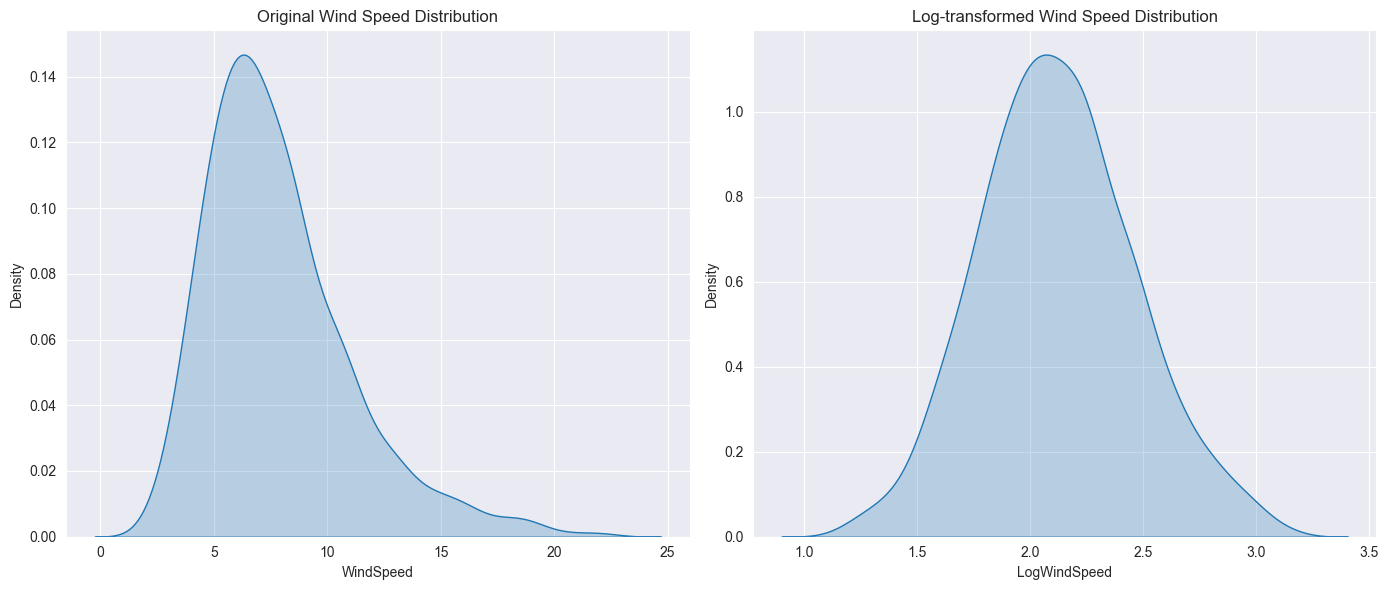

In [12]:
# 创建一个假设的风速数据集，其中包含100个正值
np.random.seed(0)
wind_speed = np.random.lognormal(mean=2, sigma=0.4, size=1000) # 生成一个对数正态分布的数据集，存在左偏，需要进行对数变换

# 创建一个DataFrame来存储风速及其对数转换的值
wind_df = pd.DataFrame({'WindSpeed': wind_speed,
                        'LogWindSpeed': np.log1p(wind_speed)})

# 绘制原始风速的分布
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(wind_df['WindSpeed'], fill=True)
plt.title('Original Wind Speed Distribution')

# 绘制对数转换后风速的分布
plt.subplot(1, 2, 2)
sns.kdeplot(wind_df['LogWindSpeed'], fill=True)
plt.title('Log-transformed Wind Speed Distribution')

plt.tight_layout()
plt.show()


## 3.2 Counts
用于聚合多个二元特征并创建一个计数特征，这种类型的特征表示某事物的存在（标记为1或True）或缺失（标记为0或False）。

这种方法的优势是能够将多个相关的二元特征简化为一个数值特征，这对于模型训练可能是有益的，因为它减少了特征的数量，同时保留了关键信息。

在此示例中，这些特征用于描述交通事故数据集中是否有某些道路对象（如十字路口、铁路道口等）靠近事故现场。

In [13]:
# 假设的交通事故数据集
data = {
    "Amenity": [False, False, True, False, True, False, False, True, False, False],
    "Bump": [False, False, False, False, False, False, False, False, False, False],
    "Crossing": [False, False, False, False, True, False, True, False, False, False],
    "GiveWay": [False, False, False, False, False, False, False, False, True, False],
    "Junction": [False, False, False, True, False, True, False, False, False, False],
    "NoExit": [False, True, False, False, False, False, False, False, False, True],
    "Railway": [False, False, False, False, False, False, True, False, False, False],
    "Roundabout": [False, False, False, False, False, True, False, False, False, False],
    "Station": [False, False, True, False, False, False, False, False, False, False],
    "Stop": [False, False, False, False, False, False, False, True, False, False],
    "TrafficCalming": [False, False, False, False, False, False, False, False, False, False],
    "TrafficSignal": [False, True, False, False, False, False, False, False, False, False]
}

accidents = pd.DataFrame(data)

# 列出所有道路特征
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
                    "Junction", "NoExit", "Railway", "Roundabout",
                    "Station", "Stop", "TrafficCalming", "TrafficSignal"]

# 计算每条记录中存在的道路特征的总数
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

# 显示数据框的前10行，最后一列为新生成的特征，表示每条记录中存在的这些道路特征的总数
accidents.head(5)


,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,True,False,False,False,False,False,True,2
2,True,False,False,False,False,False,False,False,True,False,False,False,2
3,False,False,False,False,True,False,False,False,False,False,False,False,1
4,True,False,True,False,False,False,False,False,False,False,False,False,2


## 3.3 Building-Up and Breaking-Down Features
- **Building-Up**：将多个特征组合成一个新的特征
- **Breaking-Down**：将一个特征分解成多个特征

一般可以用str accessor来进行字符串的处理，比如使用str.split()来将一个字符串特征分解成多个特征。

或者使用`str1`+`str2`来将两个字符串特征组合成一个新的特征。



## 3.4 Group Transforms
`groupby()`函数可以用于对数据进行分组，然后对每个组应用一个函数，最后将结果合并成一个数据框。

在 Pandas 中，`groupby()` 后可以跟随 `apply()`, `agg()` 或 `transform()`，这些函数都用于对分组数据进行某种操作，但它们各有特点和适用场景。

### 1. `apply()`
- `apply()` 函数对每个分组应用一个函数，可以是预定义的、匿名的或自定义的函数。这个函数可以返回一个标量、系列或数据框。
- `apply()` 是这三个函数中最灵活的，可以用于复杂的操作，如：返回多列的数据框或基于整个分组数据的计算。
- 但是，`apply()` 通常比 `agg()` 和 `transform()` 慢，特别是在处理大数据集时。

### 2. `agg()`
- `agg()`（或 `aggregate()`）函数用于应用一个或多个聚合操作到每个分组。聚合操作返回的是每个组的单个结果（如：`sum`, `mean`, `min`, `max` 等）。
- 使用 `agg()` 可以一次性对同一列应用多个聚合函数，或对不同列应用不同的聚合函数。
- `agg()` 适用于当你需要对数据分组进行简单的缩减（reduction）或汇总操作时。

### 3. `transform()`
- `transform()` 函数将一个函数应用于每个分组，然后将结果放回原来的索引位置上。返回的对象与组大小相同。
- 这对于标准化数据或填充 NaN 值非常有用，因为它允许保留数据的原始形状。
- `transform()` 适用于需要保留输入数据形状的转换操作。

每个函数都有其特定的用途，选择哪个函数取决于你的具体需求。

在 Pandas 中，`apply`、`agg` 和 `transform` 的行为确实有所不同，尤其是在处理多列数据时。这些差异主要是因为它们处理聚合操作和返回结果的方式不同。

1. **`apply()`**：
   - `apply()` 函数在分组上应用传递给它的函数，并且可以返回一个标量、系列或数据框。它在分组上应用函数，就像它在一个小型的数据框上操作一样。
   - 当使用 `lambda x: x.sum()` 时，`apply()` 对每个分组的数据框执行了 `sum()` 操作。在这个过程中，数值列被相加，而字符串列则被连接在一起，因为 `sum()` 对于字符串的默认行为是字符串连接。

2. **`agg()` 和 `transform()`**：
   - `agg()` 和 `transform()` 函数更专注于执行特定的聚合操作。当你指定 `sum` 作为聚合函数时，这两个函数只对数值列进行求和操作，并忽略非数值列。
   - 由于 `agg()` 和 `transform()` 在执行 `sum` 时不对字符串列进行操作，因此它们不会像 `apply()` 那样将字符串连接起来。

这就解释了为什么使用 `apply` 时会得到与 `agg` 和 `transform` 不同的结果。`apply` 对每个列都执行了 `sum()` 操作（包括字符串的连接），而 `agg` 和 `transform` 只对数值列执行求和。

简而言之，`apply` 在处理多列数据时的行为更为通用和灵活，但这也意味着它的行为可能会与 `agg` 和 `transform` 不同，特别是在涉及到混合类型数据时（比如同时包含字符串和数字的情况）。

In [35]:
df = pd.DataFrame({
    'Category': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Data': [1, 2, 3, 4, 5, 6]
})
print(df)

# 使用 apply()
result_apply = df.groupby('Category').apply('sum')

result2_apply= df.groupby('Category').apply(lambda x: x.sum())
# x是包含 'Category' 和 'Data' 两个列的小数据框，对每个类别 'A', 'B', 'C' 分别进行操作。当你对这样的数据框调用 sum() 方法时，它会对所有列进行求和。
# 对于数值列‘Data’，直接相加，得到3,7,11；对于字符串列‘Category’，进行拼接，得到AA,BB,CC

# 使用 agg()
result_agg = df.groupby('Category').agg('sum') # agg('sum')和agg(lambda x: x.sum())是等价的

# 使用 transform()
result_transform = df.groupby('Category').transform('sum') # transform('sum')和transform(lambda x: x.sum())是等价的

print('\napply:\n',result_apply)
print('\napply2:\n',result2_apply)
print('\nagg:\n',result_agg)
print('\ntransform:\n',result_transform)


  Category  Data
0        A     1
1        A     2
2        B     3
3        B     4
4        C     5
5        C     6

apply:
           Data
Category      
A            3
B            7
C           11

apply2:
          Category  Data
Category               
A              AA     3
B              BB     7
C              CC    11

agg:
           Data
Category      
A            3
B            7
C           11

transform:
    Data
0     3
1     3
2     7
3     7
4    11
5    11


# 4. Clustering
Clustering是一种无监督学习方法，它将数据分成不同的组，每个组称为一个cluster。每个cluster中的数据点都有一些共同的特征，而不同的cluster之间的数据点具有不同的特征。
在特征工程中，我们可以使用聚类来创建新的特征，这些特征可以帮助模型更好地理解数据。

## 4.1 K-Means Clustering